In [1]:
pip install torch torchvision matplotlib


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision


In [3]:
# Transformações para os dados
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Carregando o dataset Fashion-MNIST
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)


100%|██████████| 26421880/26421880 [00:02<00:00, 12860677.51it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 207374.81it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3900648.90it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5211749.21it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [4]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 256),
            nn.ReLU(),
            nn.Linear(256, 20)  # z_mean
        )
        self.decoder = nn.Sequential(
            nn.Linear(20, 256),
            nn.ReLU(),
            nn.Linear(256, 64 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        z_mean = self.encoder(x)
        z = z_mean + torch.randn_like(z_mean)  # reparameterization trick
        return self.decoder(z)


In [5]:
class DCGAN(nn.Module):
    def __init__(self):
        super(DCGAN, self).__init__()
        self.gen = nn.Sequential(
            nn.ConvTranspose2d(100, 256, 4, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 1, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.gen(x)


In [6]:
from torchvision.models import googlenet

# Carregando o modelo GoogLeNet pré-treinado
model = googlenet(pretrained=True)
num_classes = 10  # Para o Fashion-MNIST
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Adicionando uma função de perda e um otimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:02<00:00, 22.9MB/s]


In [7]:
def train_vae(model, data_loader, epochs):
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    model.train()
    for epoch in range(epochs):
        for data in data_loader:
            optimizer.zero_grad()
            output = model(data[0])
            loss = nn.MSELoss()(output, data[0])  # Usando MSE Loss
            loss.backward()
            optimizer.step()
    print(f'Training VAE for {epochs} epochs complete.')

# Treinando o VAE
vae = VAE()
train_vae(vae, train_loader, epochs=5)


Training VAE for 5 epochs complete.


In [13]:
def train_googlenet(model, data_loader, epochs):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in data_loader:
            optimizer.zero_grad()
            # Convert grayscale images to 3 channels by repeating the channel
            images = images.repeat(1, 3, 1, 1)  # Repeat along channels dimension
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {running_loss / len(data_loader):.4f}')

# Treinando o GoogLeNet
train_googlenet(model, train_loader, epochs=5)

Epoch [1/5], Loss: 0.4638
Epoch [2/5], Loss: 0.3063
Epoch [3/5], Loss: 0.2670
Epoch [4/5], Loss: 0.2526
Epoch [5/5], Loss: 0.2279


In [23]:
def evaluate_googlenet(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')

# Avaliando o GoogLeNet
evaluate_googlenet(model, test_loader)


IndexError: index 1 is out of bounds for dimension 1 with size 1

In [25]:
def evaluate_googlenet(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            # Convert grayscale images to 3 channels by repeating the channel
            images = images.repeat(1, 3, 1, 1)  # Repeat along channels dimension
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')

# Avaliando o GoogLeNet
evaluate_googlenet(model, test_loader)

Accuracy: 90.83%


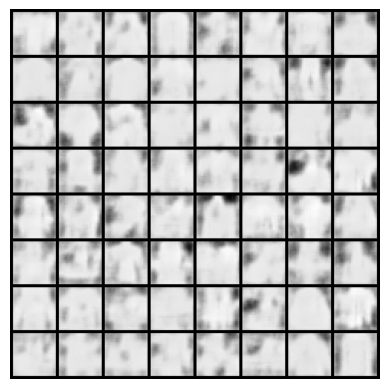

In [21]:
def visualize_results(model):
    with torch.no_grad():
        sample = torch.randn(64, 20)  # Amostras aleatórias
        generated_images = model.decoder(sample).view(-1, 1, 28, 28)
        grid = torchvision.utils.make_grid(generated_images, nrow=8, normalize=True)
        plt.imshow(grid.permute(1, 2, 0).numpy())
        plt.axis('off')
        plt.show()

# Visualizando os resultados
visualize_results(vae)
